In [872]:
# XGboost: hyperparameters
# scale_pos_weight: unbalance dataset . value = sum(negative cases)/ sum(postive case)
# eval_metric: Use AUC for false postive, error for accuracy etc

# 1. Loading dependencies & datasets

In [873]:
!pip install xgBoost

In [874]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline



from imblearn.over_sampling import SMOTE


import re

In [875]:
data = pd.read_csv('./kaggle/input/train.csv')

In [876]:
#initial check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [877]:
ids = ['id','circle_id']
#select usefull column based on businees understanding
# total_amount: recharge+data+packs
# total_outgoing_calls_minute
# offnetwork_minutes
# average_revenue_per_user_3g
# volume_of_3g_data_used
# volume_of_2g_data_used
# age_on_network
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']
data = data[variables].set_index('id')

In [878]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


In [879]:
#dataType

In [880]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

In [881]:
##summary of the features

In [882]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


In [883]:
# Check Target Column. data is baised

In [884]:
data['churn_probability'].value_counts() * 100/len(data)

churn_probability
0    89.811283
1    10.188717
Name: count, dtype: float64

In [885]:
# lets Drop X and Y since it has onyl one value

In [886]:
data['circle_id'].value_counts()

circle_id
109    69999
Name: count, dtype: int64

In [887]:
data.columns

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'churn_probability'],
      dtype='object')

In [888]:
data.drop('circle_id',axis=1, inplace=True)

# filter high value customer

get the rech amount mean for month 6, 7 and select customer top 30 quantile 

In [889]:
data['AVG_amt_6_7'] = data[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)

In [890]:
data[['AVG_amt_6_7', 'total_rech_amt_6', 'total_rech_amt_7']].quantile([0.25,.5,.7])

,AVG_amt_6_7,total_rech_amt_6,total_rech_amt_7
0.25,115.0,110.0,100.0
0.50,229.0,229.0,220.0
0.70,370.0,378.0,370.0


In [891]:
data.shape

(69999, 24)

In [892]:
# data = data[data['AVG_amt_6_7'] > data['AVG_amt_6_7'].quantile(.5)]

In [893]:
data = data.drop('AVG_amt_6_7', axis = 1)

In [894]:
data.shape

(69999, 23)

In [895]:
data.columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'churn_probability'],
      dtype='object')

In [896]:
data['churn_probability'].value_counts()/len(data)

churn_probability
0    0.898113
1    0.101887
Name: count, dtype: float64

# 2- EDA

In [897]:
# unvariant analysis : lots of outlier

<Axes: >

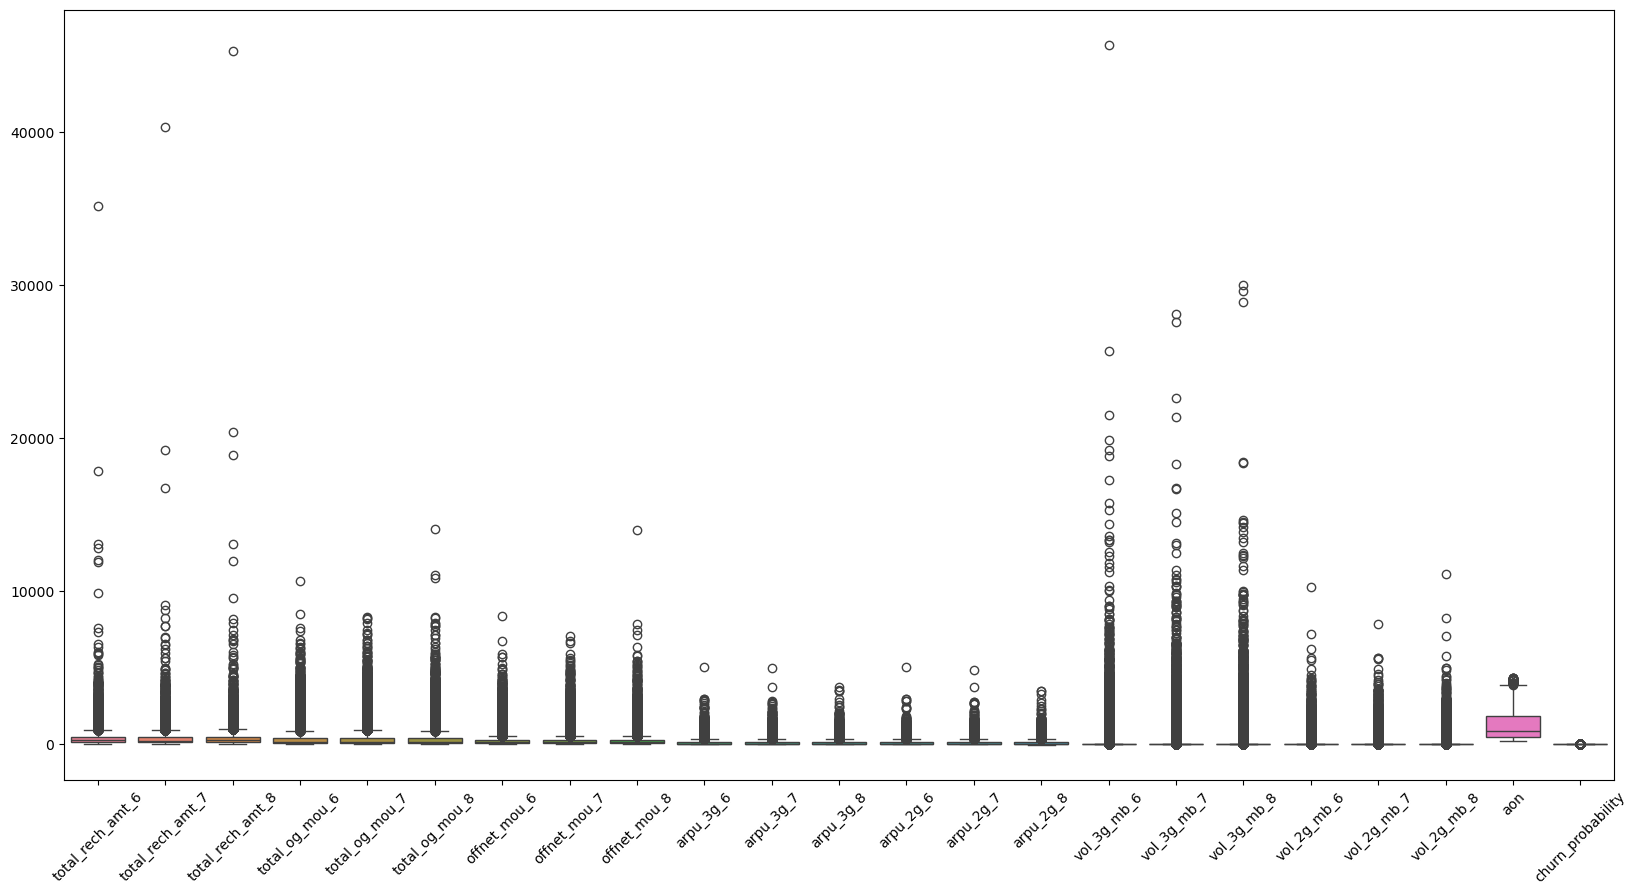

In [898]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.boxplot(data=data)

In [899]:
# bivariant analysis - num  vs num
# bivariant with target

In [900]:
# sns.pairplot(data)



<Axes: xlabel='churn_probability', ylabel='Count'>

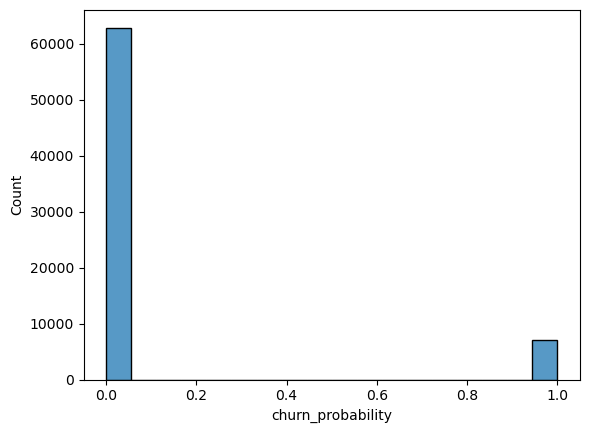

In [901]:
#Distribution for the churn probability
sns.histplot(data['churn_probability'])

<Axes: >

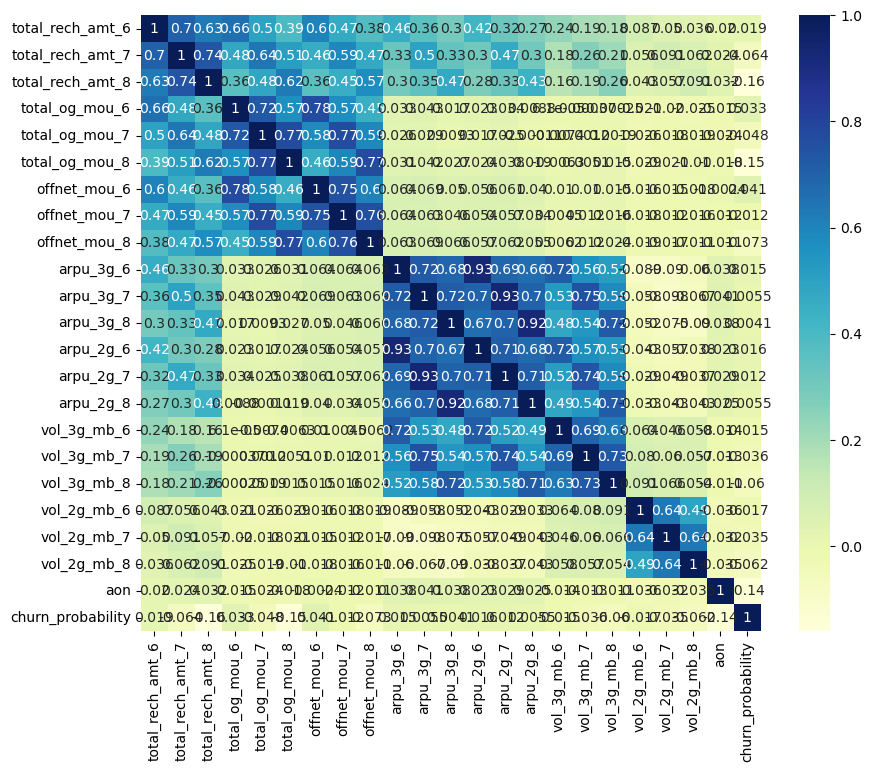

In [902]:
plt.figure(figsize=(10,8 ))
sns.heatmap(data.corr(), annot=True, cmap = 'YlGnBu')

# 3. Create X, y and then Train test split

In [903]:
y = data.pop('churn_probability')
X = data
print(X.shape, y.shape)

(69999, 22) (69999,)


In [904]:
# Splitting data into train and test

In [905]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.2)

X_train.shape,  X_test.shape, y_train.shape, y_train.shape

((55999, 22), (14000, 22), (55999,), (55999,))

In [906]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
28082,174,306,570,0.00,170.93,480.53,70.94,193.26,346.31,NaN,...,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.0,0.00,2508
15453,110,110,425,188.78,136.46,322.04,99.39,36.31,289.09,NaN,...,NaN,NaN,121.78,0.0,0.0,290.44,0.00,0.0,306.22,1805
19196,183,210,262,12.68,24.74,61.83,12.24,18.68,61.68,0.0,...,63.71,NaN,70.97,0.0,0.0,0.00,777.84,0.0,592.33,737
34626,0,0,50,69.94,14.79,37.21,68.41,14.79,28.56,NaN,...,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.0,0.00,2038
33144,160,0,0,43.78,57.66,0.00,43.11,51.78,0.00,NaN,...,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.0,0.00,668


# 4. Preprocessing

## 4.1 handling missing data

In [907]:
# Lets analyse missing data

In [908]:
missing_per = X_train.isna().mean()*100
missing_per


total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.966142
offnet_mou_7         3.841140
offnet_mou_8         5.287594
arpu_3g_6           75.040626
arpu_3g_7           74.508473
arpu_3g_8           73.692387
arpu_2g_6           75.040626
arpu_2g_7           74.508473
arpu_2g_8           73.692387
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
dtype: float64

In [909]:
# Since lots if missing value in some column . drop column with more than 40% missing values

In [910]:
columns_to_drop = missing_per[missing_per > 40].index

In [911]:
columns_to_drop

Index(['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7',
       'arpu_2g_8'],
      dtype='object')

In [912]:
X_train_filtered = X_train.drop(columns_to_drop, axis =1)

In [913]:
X_train_filtered.shape

(55999, 16)

Apply imputation on missing data. 
 We can use either
 1. constant value
 2. mean or median 
 3. Use MICE

 Lets use simple constant value for now

In [914]:
impute_cols = X_train_filtered.columns[X_train_filtered.isna().any()]
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [915]:
len(X_train_filtered.columns)

16

In [916]:
X_train_filtered.columns

 # "['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'] not in index"

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [917]:
si = KNNImputer(n_neighbors=10)
X_train_filtered[impute_cols] = si.fit_transform(X_train_filtered[impute_cols])

In [918]:
# check if there are any null after imputation

In [919]:
X_train_filtered.isna().any().sum()

np.int64(0)

## 4.2 handling outlier

Box plot clearly shpw there are lots if outlier. We can deal with them either
1. 1.5 * IQR
2. K sigma 
lets use K = 3 sigma for now and kap the outlier to lower and upper limit

In [920]:
def cap_outlier(array , k =3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array < lower_limit ] = lower_limit
    array[array > upper_limit] = upper_limit
    return array

/var/folders/c7/yz2nglzd79x58f_yf_s__z2m0000gn/T/ipykernel_97324/603258457.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1493.3956054453063' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  array[array > upper_limit] = upper_limit
/var/folders/c7/yz2nglzd79x58f_yf_s__z2m0000gn/T/ipykernel_97324/603258457.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1481.6835280911152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  array[array > upper_limit] = upper_limit
/var/folders/c7/yz2nglzd79x58f_yf_s__z2m0000gn/T/ipykernel_97324/603258457.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1520.6746843222636' has dtype incompatible with int64, please explicit

<Axes: >

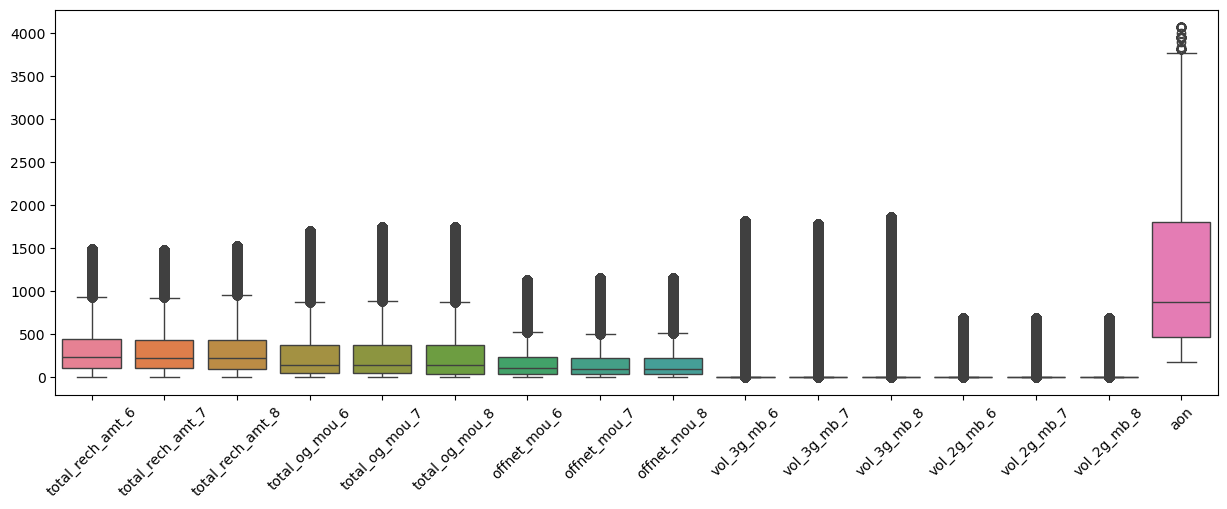

In [921]:
X_train_filtered1 = X_train_filtered.apply(cap_outlier, axis = 0)

# axis = 1 along the column ➡️ Right
# axis = 0 along the rows ⬇️ 


plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.boxplot(data=X_train_filtered1)

## 4.3 Feature scaling

In [922]:
sc = StandardScaler()
X_train_filtered2 = sc.fit_transform(X_train_filtered1)

In [923]:
X_train_filtered2 = pd.DataFrame(X_train_filtered2, columns = X_train_filtered1.columns)

<Axes: >

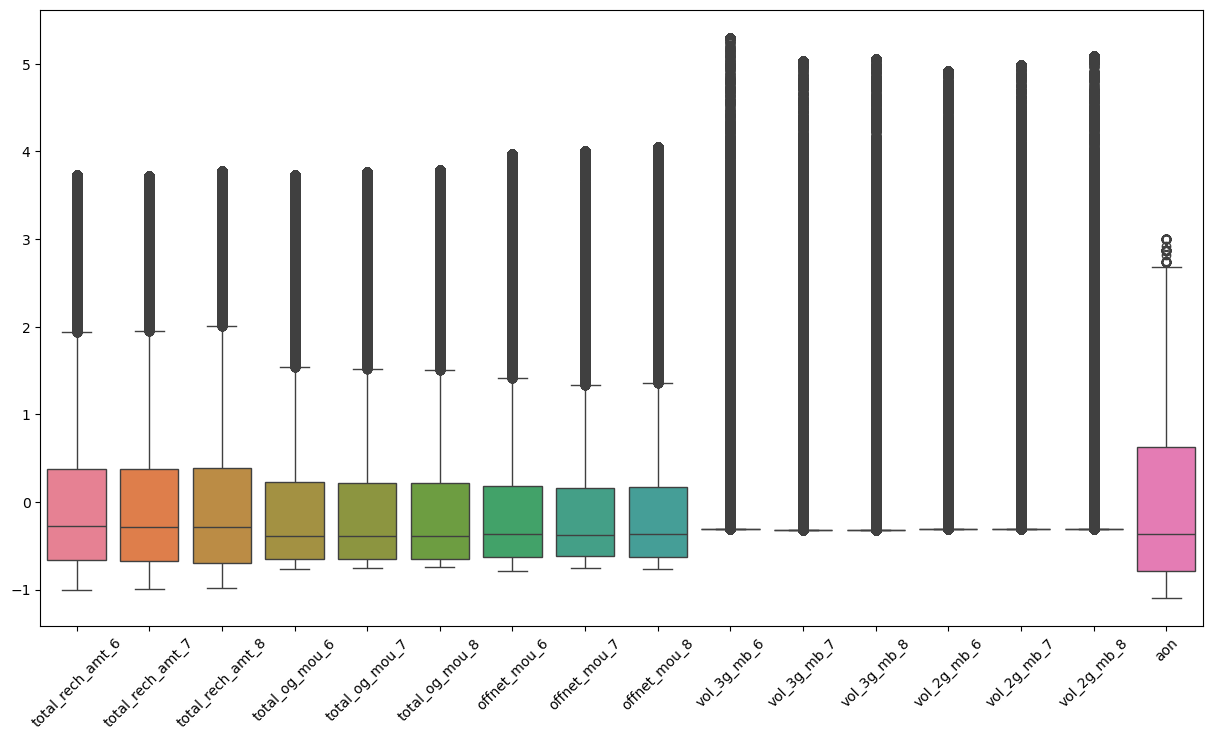

In [924]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data= X_train_filtered2)

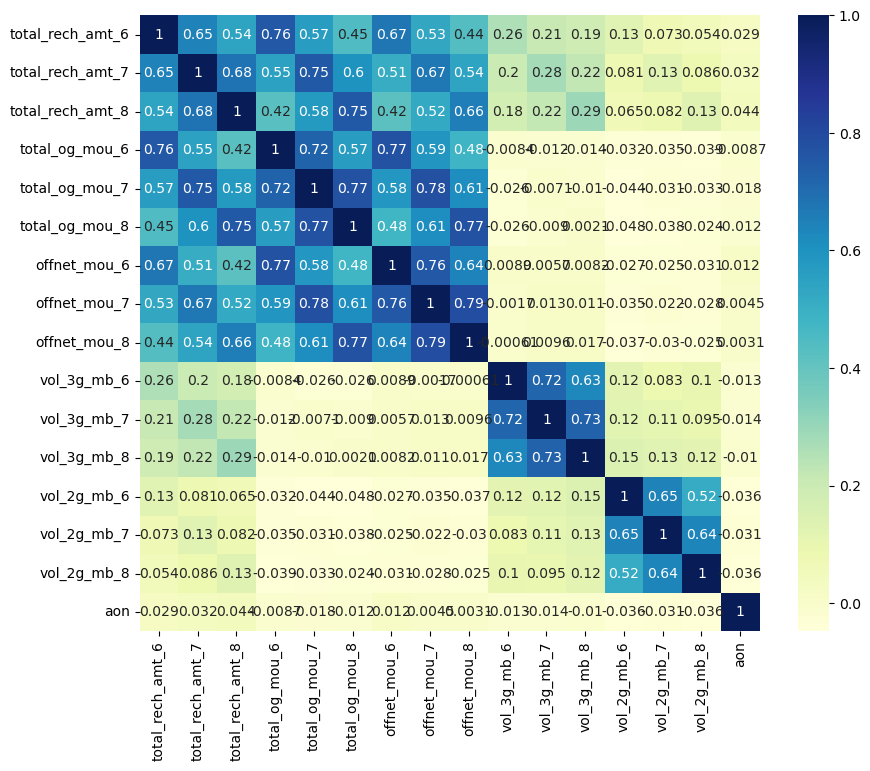

In [925]:
plt.figure(figsize=(10,8))
sns.heatmap(data = X_train_filtered2.corr(), cmap= 'YlGnBu' , annot=True)
plt.show()

# 5. Feature engineering and selection

 Lets understand feature importance

In [926]:
y_train.shape, X_train.shape, X_train_filtered2.shape

((55999,), (55999, 22), (55999, 16))

In [927]:
rf = RandomForestClassifier(n_estimators = 100, random_state=110, n_jobs=-1)
rf = rf.fit(X_train_filtered2, y_train)


In [928]:
rf.feature_importances_

array([0.05171299, 0.05491354, 0.12059215, 0.05753072, 0.08456457,
       0.25839886, 0.06121516, 0.06411678, 0.09238785, 0.00976037,
       0.01099016, 0.0127324 , 0.01398682, 0.01628398, 0.02131098,
       0.06950266])

In [929]:
importance_df = pd.DataFrame( {'value' : rf.feature_importances_, 'name':list(X_train_filtered2.columns)}) 


In [930]:
importance_df.sort_values(by='value', ascending=False)

,value,name
5,0.258399,total_og_mou_8
2,0.120592,total_rech_amt_8
8,0.092388,offnet_mou_8
4,0.084565,total_og_mou_7
15,0.069503,aon
7,0.064117,offnet_mou_7
6,0.061215,offnet_mou_6
3,0.057531,total_og_mou_6
1,0.054914,total_rech_amt_7
0,0.051713,total_rech_amt_6


In [931]:
# create new feature, average change 

# in usage
# average % gain of 3g volumne

In [932]:
X_train_filtered2.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
0,-0.458127,-0.017807,0.800288,-0.768655,-0.315064,0.500561,-0.484875,0.044196,0.678303,-0.308361,-0.317885,-0.323597,-0.314642,-0.312491,-0.309257,1.356366
1,-0.661291,-0.640030,0.347389,-0.268365,-0.404173,0.088821,-0.365111,-0.607037,0.439660,-0.308361,-0.317885,0.516488,-0.314642,-0.312491,2.094203,0.617209
2,-0.429557,-0.322570,-0.161732,-0.735052,-0.692981,-0.587175,-0.731979,-0.680189,-0.508784,-0.308361,-0.317885,-0.323597,4.913811,-0.312491,4.339825,-0.505722
3,-1.010479,-0.989237,-0.823902,-0.583306,-0.718702,-0.651135,-0.495525,-0.696330,-0.646915,-0.308361,-0.317885,-0.323597,-0.314642,-0.312491,-0.309257,0.862193
4,-0.502569,-0.989237,-0.980074,-0.652633,-0.607879,-0.747803,-0.602028,-0.542847,-0.766028,-0.308361,-0.317885,-0.323597,-0.314642,-0.312491,-0.309257,-0.578271


In [933]:
# X_train_filtered2['avg_per_gain_3g'] = (X_train_filtered2['vol_3g_mb_6'] - X_train_filtered2['vol_3g_mb_7'])/ X_train_filtered2['vol_3g_mb_6']
# X_train_filtered2= X_train_filtered2.drop('avg_per_gain_3g', axis =1 )

#TODO : Crete New features
1.  "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. data['recharge_data_ratio'] = data['recharge_data_mnth'] / (data['total_recharge_mnth'] + 1)
4. data['outgoing_calls_recharge'] = data['total_outgoing_call_mnth'] * data['recharge_amt_mnt']



Lets Apply SMOTE for class imbalance as the Random forest return all class level as 0

In [934]:
X_train_filtered_f, y_train_f = X_train_filtered2, y_train

In [935]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=110)
# X_train_filtered_f, y_train_f = smote.fit_resample(X_train_filtered2, y_train)


In [936]:
# X_train_filtered2.shape, y_train.shape, X_train_filtered_f.shape, y_train_f.shape

 lets use PCA to create new feature


In [937]:
# pca = PCA()
# pca_components = pca.fit_transform(X_train_filtered_f)

# sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_f)

In [938]:
# rf = RandomForestClassifier()
# rf.fit(pca_components, y_train_f)
# feature_importance_df = pd.DataFrame( 
#     {'value' : rf.feature_importances_, 'name':['comp_'+ str(i) for i in range(len(rf.feature_importances_))]}
# ) 

In [939]:
# plt.figure(figsize=(15,8))
# plt.xticks(rotation=45)
# sns.barplot(x=feature_importance_df['name'], y =feature_importance_df['value'])


# 6 - Modelling 

lets create model with logistci regression on 2 PCA componenet

In [940]:
# lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
# lr.fit(pca_components[:,:2], y_train_f)

In [941]:
# accuracy_score(y_train_f, lr.predict(pca_components[:,:2]))

model has 89% accuracy

lets create a pipeline

In [942]:
#logistic regression

In [943]:
imp = KNNImputer(n_neighbors=10)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=100)

In [944]:
pipe_lr = Pipeline([
    ('imputation', imp),
    ('scaling', scale),
    ('pca', scale),
    ('model', lr)
])

In [945]:
# random forest

In [946]:

rf = RandomForestClassifier(n_estimators=100)


In [947]:
xgb = XGBClassifier(random_state=110, n_estimators=100)

In [948]:
pipe_rf = Pipeline([
    ('imputation', imp),
    ('scaling', scale),
    ('pca', scale),
    ('model', rf)
])

In [949]:
pipe_xgb = Pipeline([
    ('imputation', imp),
    ('scaling', scale),
    ('pca', scale),
    ('model', xgb)
])

-----------------------------------------------------LR Pred

In [950]:
# process test data
cols = X_train_filtered_f.columns
X_test_f = X_test[cols]
y_test_f = y_test


In [951]:
y_test.value_counts()

churn_probability
0    12574
1     1426
Name: count, dtype: int64

In [952]:
# utility function
def get_score_confusion_matrix(pipeline, X_data, y_data):
    pipeline.fit(X_data, y_data)
    print('accuracy score : ',accuracy_score(y_data, pipeline.predict(X_data)))
    print( 'confustion matrix : ' ,confusion_matrix(y_data, pipeline.predict(X_data)))


In [953]:
# pipe = pipe_lr
# pipe.fit(X_train_filtered, y_train)
# accuracy_score(y_train, pipe.predict(X_train_filtered))
#confusion_matrix(y_train, pipe.predict(X_train_filtered))
# (tn, fp, fn, tp) = cm.ravel()
# (tn, fp, fn, tp) # positive = churn = 1 # negative = non-churn = 0 false positive are high

-----------------------------------------------------LR Pred

In [954]:
get_score_confusion_matrix(pipe_lr, X_train_filtered_f, y_train_f)

accuracy score :  0.9134627404060787
confustion matrix :  [[49899   394]
 [ 4452  1254]]


test score

In [955]:
get_score_confusion_matrix(pipe_lr, X_test_f, y_test_f)

accuracy score :  0.9042857142857142
confustion matrix :  [[12328   246]
 [ 1094   332]]


-----------------------------------------------------DT Pref

 train score

In [956]:
get_score_confusion_matrix(pipe_rf, X_train_filtered_f, y_train_f)

accuracy score :  0.9999464276147788
confustion matrix :  [[50293     0]
 [    3  5703]]


 test score

In [957]:
get_score_confusion_matrix(pipe_rf,  X_test_f, y_test_f)

accuracy score :  0.898
confustion matrix :  [[12572     2]
 [ 1426     0]]


-----------------------------------------------------XGB Pred

train score

In [958]:
get_score_confusion_matrix(pipe_xgb, X_train_filtered_f, y_train_f)

accuracy score :  0.9605171520920016
confustion matrix :  [[49774   519]
 [ 1692  4014]]


test score

In [959]:
get_score_confusion_matrix(pipe_xgb,  X_test_f, y_test_f)

accuracy score :  0.8991428571428571
confustion matrix :  [[12529    45]
 [ 1367    59]]


In [960]:
X_test.columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

HyperParameter Tuning


In [961]:
# %timeit
# param_grid_rf = {
# 'model__n_estimators':[100,150,200],
# 'model__max_depth':[2,3,5,7,10],
# 'model__min_samples_split':[10,20,30,40],
# 'model__max_leaf_nodes':[20,40,60,80,100]
# }
# cv_rf = GridSearchCV(estimator=pipe_rf, n_jobs=-1, param_grid = param_grid_rf, verbose=2, cv=5, scoring='accuracy')
# cv_rf.fit( X_train_filtered_f, y_train_f)



In [962]:
# rf_best_params_ = {max_depth=10, max_leaf_nodes=80, min_samples_split=40,
#                        n_estimators=150}

In [963]:
# cv.best_estimator_

In [964]:
# %timeit
# param_grid_xgb = {
# 'model__n_estimators':[50,150,200],
# 'model__max_depth':[3,6,9],
# 'model__learning_rate' : [0.01, 0.1, 0.2],
# 'model__min_child_weight': [1, 3, 5],
# 'model__colsample_bytree': [0.8, 0.9, 1.0], 
# 'model__gamma':[0, 0.1, 0.2],
# 'model__reg_lambda':[1,2,5,10],
# 'model__subsample':[0.8]
# }

# cv_xgb = GridSearchCV(estimator=pipe_xgb, n_jobs=-1, param_grid = param_grid_xgb, verbose=2, cv=5, scoring='accuracy')
# cv_xgb.fit( X_train_filtered_f, y_train_f)

In [965]:
# cv_xgb.best_params_
{'model__colsample_bytree': 0.9,
 'model__gamma': 0,
 'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__min_child_weight': 3,
 'model__n_estimators': 150,
 'model__reg_lambda': 10,
 'model__subsample': 0.8}

{'model__colsample_bytree': 0.9,
 'model__gamma': 0,
 'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__min_child_weight': 3,
 'model__n_estimators': 150,
 'model__reg_lambda': 10,
 'model__subsample': 0.8}

In [966]:
# cv.best_estimator_

In [967]:
rf = RandomForestClassifier(max_depth=10, max_leaf_nodes=80, min_samples_split=40,
                       n_estimators=150)
pipe_rf = Pipeline([
    ('imputation', imp),
    ('scaling', scale),
    ('pca', scale),
    ('model', rf)
])


In [968]:
get_score_confusion_matrix(pipe_rf, X_train_filtered_f, y_train_f)

accuracy score :  0.9429989821246808
confustion matrix :  [[49472   821]
 [ 2371  3335]]


In [969]:
get_score_confusion_matrix(pipe_rf,  X_test_f, y_test_f)

accuracy score :  0.8981428571428571
confustion matrix :  [[12574     0]
 [ 1426     0]]


In [970]:
xgb = XGBClassifier(colsample_bytree= 0.9,
  gamma= 0,
 learning_rate= 0.1,
 max_depth= 3,
 min_child_weight= 3,
 n_estimators= 150,
 reg_lambda= 10,
 subsample= 0.8)

pipe_xgb = Pipeline([
    ('imputation', imp),
    ('scaling', scale),
    ('pca', scale),
    ('model', xgb)
])

In [971]:
get_score_confusion_matrix(pipe_xgb, X_train_filtered_f, y_train_f)

accuracy score :  0.939838211396632
confustion matrix :  [[49351   942]
 [ 2427  3279]]


In [864]:
get_score_confusion_matrix(pipe_xgb,  X_test_f, y_test_f)

accuracy score :  0.917095483133219
confustion matrix :  [[6416    0]
 [ 580    0]]


# 7. Creating submission file

Sample output file will contain custmer_id, prediction

In [983]:
# load test file
unseen_data = pd.read_csv('./kaggle/input/test.csv')
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [984]:
submission_data = unseen_data.set_index('id')

In [985]:
cols = X_train_filtered_f.columns
submission_data = submission_data[cols]
submission_data.shape

(30000, 16)

In [986]:
pipe_final = pipe_rf

In [987]:
unseen_data['churn_probability'] = pipe_final.predict(submission_data)
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0


In [988]:
output = unseen_data[['id','churn_probability']]
output.head()



,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [989]:
output.to_csv('./kaggle/output/submission_telecom_churn.csv', index=False)